In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD

In [13]:
# Directorios de entrenamiento, validación y prueba TAMBIEN MODIFICAR NUM_CLASS Y BEST_MODEL 
train_dir = r'D:\Python\TESIS\CLUSTERS_C1_CALC_K\train'
val_dir = r'D:\Python\TESIS\CLUSTERS_C1_CALC_K\val'
test_dir = r'D:\Python\TESIS\CLUSTERS_C1_CALC_K\test'

In [14]:
# Configurar TensorFlow para que use solo la GPU 0 y optimizar el uso de la memoria
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU configurada correctamente.")
    except RuntimeError as e:
        print(e)

# Parámetros de la red y del entrenamiento
img_width, img_height = 170, 170  # Ajustado al lienzo de 170x170 píxeles
batch_size = 64
epochs = 100
num_classes = 3  # Número de categorías
l2 = 0.02 

# Generadores de datos para la carga y preprocesamiento de imágenes en escala de grises
train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Generadores para train, val y test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)  # No se necesita barajar para evaluar

GPU configurada correctamente.
Found 870 images belonging to 3 classes.
Found 176 images belonging to 3 classes.
Found 91 images belonging to 3 classes.


In [17]:
# Crear el modelo
model = Sequential()

# Primera capa convolucional con regularización L2
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 1), kernel_regularizer=regularizers.l2(l2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda capa convolucional con regularización L2
model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(l2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Tercera capa convolucional con regularización L2
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(l2)))
model.add(Activation('relu'))

# Cuarta capa convolucional con regularización L2
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(l2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanar las capas convolucionales para conectarlas con capas densas
model.add(Flatten())

# Capa densa con regularización L2 y Dropout
model.add(Dense(128, kernel_regularizer=regularizers.l2(l2)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Capa de salida
model.add(Dense(num_classes, kernel_regularizer=regularizers.l2(l2)))
model.add(Activation('softmax'))

# Compilar el modelo con el optimizador SGD, una tasa de aprendizaje inicial baja y decaimiento
#optimizer = SGD(learning_rate=1e-4, momentum=0.9, decay=1e-6)
optimizer=Adam(learning_rate=1e-4)

# Configuración del modelo de entrenamiento
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Callbacks para guardar el mejor modelo y detener temprano
checkpoint = ModelCheckpoint('best_model_C1.h5', verbose=1, save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint, early_stopping],
    workers=tf.data.experimental.AUTOTUNE,
    use_multiprocessing=True)

# Evaluación del modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 8.5805 - accuracy: 0.4417
Epoch 1: val_loss improved from inf to 8.02202, saving model to best_model_C1.h5
13/13 [==============================] - 3s 128ms/step - loss: 8.5805 - accuracy: 0.4417 - val_loss: 8.0220 - val_accuracy: 0.4297
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 7.5106 - accuracy: 0.6214
Epoch 2: val_loss improved from 8.02202 to 6.97383, saving model to best_model_C1.h5
13/13 [==============================] - 1s 113ms/step - loss: 7.5106 - accuracy: 0.6214 - val_loss: 6.9738 - val_accuracy: 0.8672
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 6.5843 - accuracy: 0.6600
Epoch 3: val_loss improved from 6.97383 to 6.05787, saving model to best_model_C1.h5
13/13 [==============================] - 1s 114ms/step - loss: 6.5843 - accuracy: 0.6600 - val_loss: 6.0579 - val_accuracy: 0.8359
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 5.

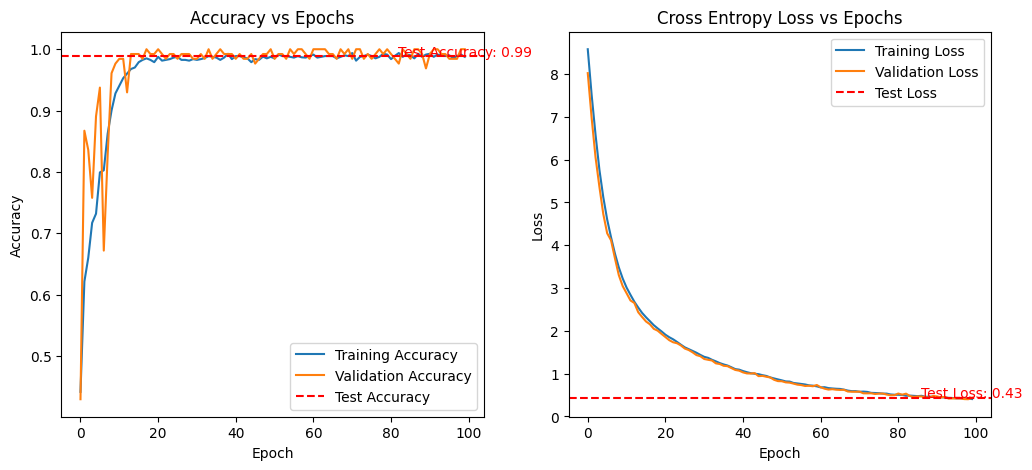

In [18]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Línea para Test
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.text(len(history.history['accuracy']) - 1, test_accuracy, f'Test Accuracy: {test_accuracy:.2f}', color='r', ha='center')


# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Línea para Test
plt.title('Cross Entropy Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.text(len(history.history['loss']) - 1, test_loss, f'Test Loss: {test_loss:.2f}', color='r', ha='center')

plt.show()
